In [1]:
import cftime
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy.stats import genextreme as gev
from scipy import stats
import xclim as xc
from xclim import sdba
from xclim.sdba import nbutils

from unseen import fileio
from unseen import eva
from unseen import moments
from unseen import similarity
from unseen import stability
from unseen import bias_correction
from unseen import time_utils

/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/xclim/sdba/__init__.py:22: FutureWarning: The SDBA submodule is in the process of being split from `xclim` in order to facilitate development and effective maintenance of the SDBA utilities. The `xclim.sdba` functionality will change in the future. For more information, please visit https://xsdba.readthedocs.io/en/latest/.
  warnings.warn(


In [2]:
lat = {}
lon = {}

lat['Katherine'] = -14.5
lon['Katherine'] = 132.3

lat['Surat'] = -27.2
lon['Surat'] = 149.1

lat['Miena'] = -42.0
lon['Miena'] = 146.7

In [3]:
location = 'Surat'

### Observations

In [4]:
txx_obs_file = '/Users/irv033/Desktop/unseen-bias/txx_AGCD-CSIRO_1901-2024_annual-jul-to-jun_AUS300i.nc'

In [5]:
ds_obs = fileio.open_dataset(txx_obs_file)

In [6]:
da_obs = ds_obs['tasmax'].sel({'lat': lat[location], 'lon': lon[location]}, method='nearest')

In [7]:
da_obs = da_obs.compute()

/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/xstatstests/scipy.py:246: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  outputs = func(args, **scipy_kwargs)
/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/xstatstests/scipy.py:246: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  outputs = func(args, **scipy_kwargs)
/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/xstatstests/scipy.py:246: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  outputs = func(args, **scipy_kwargs)


In [8]:
df_obs = da_obs.to_dataframe()

In [9]:
ranked_years = df_obs.sort_values(by='tasmax', ascending=False)
print(ranked_years.head(n=10))

                      lat    lon  event_time     tasmax
time                                                   
2017-06-30 00:00:00 -27.0  149.5  2017-02-12  44.766861
2014-06-30 00:00:00 -27.0  149.5  2014-01-03  44.689911
1914-06-30 00:00:00 -27.0  149.5  1913-12-04  44.303989
1940-06-30 00:00:00 -27.0  149.5  1940-01-25  43.796501
1932-06-30 00:00:00 -27.0  149.5  1932-01-10  43.707714
2021-06-30 00:00:00 -27.0  149.5  2020-12-02  43.580250
1931-06-30 00:00:00 -27.0  149.5  1931-01-12  43.336033
1929-06-30 00:00:00 -27.0  149.5  1929-01-18  43.158810
1942-06-30 00:00:00 -27.0  149.5  1942-01-04  43.152298
1952-06-30 00:00:00 -27.0  149.5  1951-12-07  42.972881


In [10]:
linear_fit_obs = np.polyfit(da_obs.time.dt.year.values, da_obs.values, 1)
linear_data_obs = np.polyval(linear_fit_obs, da_obs.time.dt.year.values)

In [11]:
base_mean_obs = da_obs.sel(time=slice('1972-01-01', '2018-12-31')).mean().values

In [12]:
da_obs_detrended = (da_obs - linear_data_obs) + base_mean_obs
da_obs_detrended.attrs = da_obs.attrs

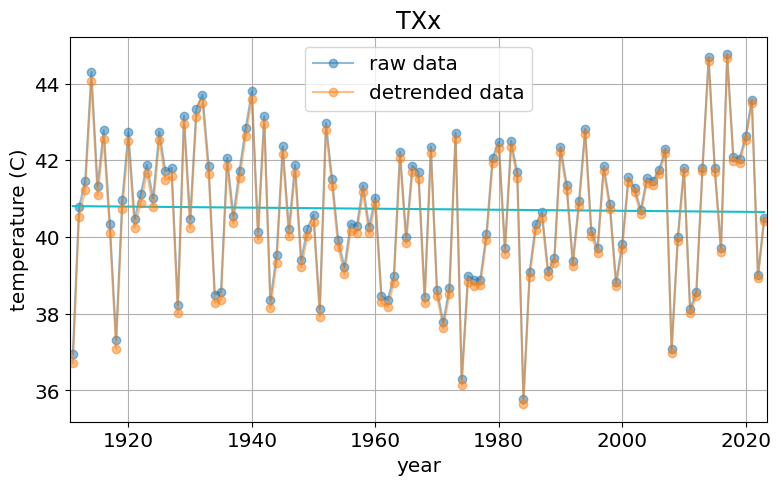

In [13]:
fig, ax = plt.subplots(figsize=[9, 5])
years = da_obs['time'].dt.year.values
plt.plot(years, da_obs.values, marker='o', label='raw data', color='tab:blue', alpha=0.5)
plt.plot(years, linear_data_obs, color='tab:cyan')
plt.plot(years, da_obs_detrended.values, marker='o', label='detrended data', color='tab:orange', alpha=0.5)
plt.xlim(years[0] - 0.5, years[-1] + 0.5)
plt.title('TXx')
plt.ylabel('temperature (C)')
plt.xlabel('year')
plt.legend()
plt.grid()

In [14]:
gev_shape_obs_detrended, gev_loc_obs_detrended, gev_scale_obs_detrended = eva.fit_gev(da_obs_detrended.values)
print(f'Shape parameter: {gev_shape_obs_detrended:.2f}')
print(f'Location parameter: {gev_loc_obs_detrended:.2f}')
print(f'Scale parameter: {gev_scale_obs_detrended:.2f}')

Shape parameter: 0.34
Location parameter: 39.97
Scale parameter: 1.87


### Model data

In [15]:
txx_model_file = '/Users/irv033/Desktop/unseen-bias/txx_CanESM5-dcppA-hindcast_196101-201701_annual-jul-to-jun_AUS300i.nc'

In [16]:
ds_model = fileio.open_dataset(txx_model_file)

In [17]:
da_model = ds_model['tasmax'].sel({'lat': lat[location], 'lon': lon[location]}, method='nearest')

In [18]:
da_model = da_model.compute()

In [19]:
da_model_stacked = da_model.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [20]:
linear_fit_model = np.polyfit(da_model_stacked.time.dt.year.values, da_model_stacked.values, 1)
linear_data_model = np.polyval(linear_fit_model, np.unique(da_model_stacked.time.dt.year.values))

In [21]:
da_model_stacked_base = time_utils.select_time_period(da_model_stacked.copy(), ['1972-01-01', '2018-12-31'])
base_mean_model = da_model_stacked_base.mean().values

In [22]:
value_year_pairs = np.column_stack((da_model_stacked.values, da_model_stacked.time.dt.year.values))
detrended_data = []
for value, year in value_year_pairs:
    af = np.polyval(linear_fit_model, year)
    detrended_value = value - af + base_mean_model
    detrended_data.append(detrended_value)
detrended_data = np.array(detrended_data)

In [23]:
da_model_detrended_stacked = da_model_stacked * 0 + detrended_data
da_model_detrended_stacked.attrs = da_model_stacked.attrs

In [24]:
da_model_detrended = da_model_detrended_stacked.unstack()

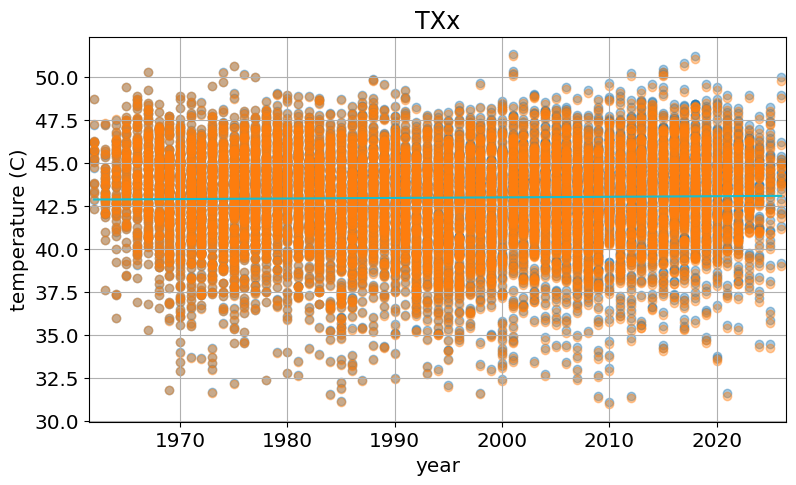

In [25]:
fig, ax = plt.subplots(figsize=[9, 5])
years = da_model_stacked['time'].dt.year.values
unique_years = np.unique(da_model_stacked.time.dt.year.values)
plt.scatter(years, da_model_stacked.values, marker='o', color='tab:blue', alpha=0.4, label='raw data')
plt.plot(unique_years, linear_data_model, color='tab:cyan')
plt.scatter(years, da_model_detrended_stacked.values, marker='o', color='tab:orange', alpha=0.4, label='detrended data')
plt.xlim(unique_years[0] - 0.5, unique_years[-1] + 0.5)
plt.title('TXx')
plt.ylabel('temperature (C)')
plt.xlabel('year')
#plt.legend()
plt.grid()

/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


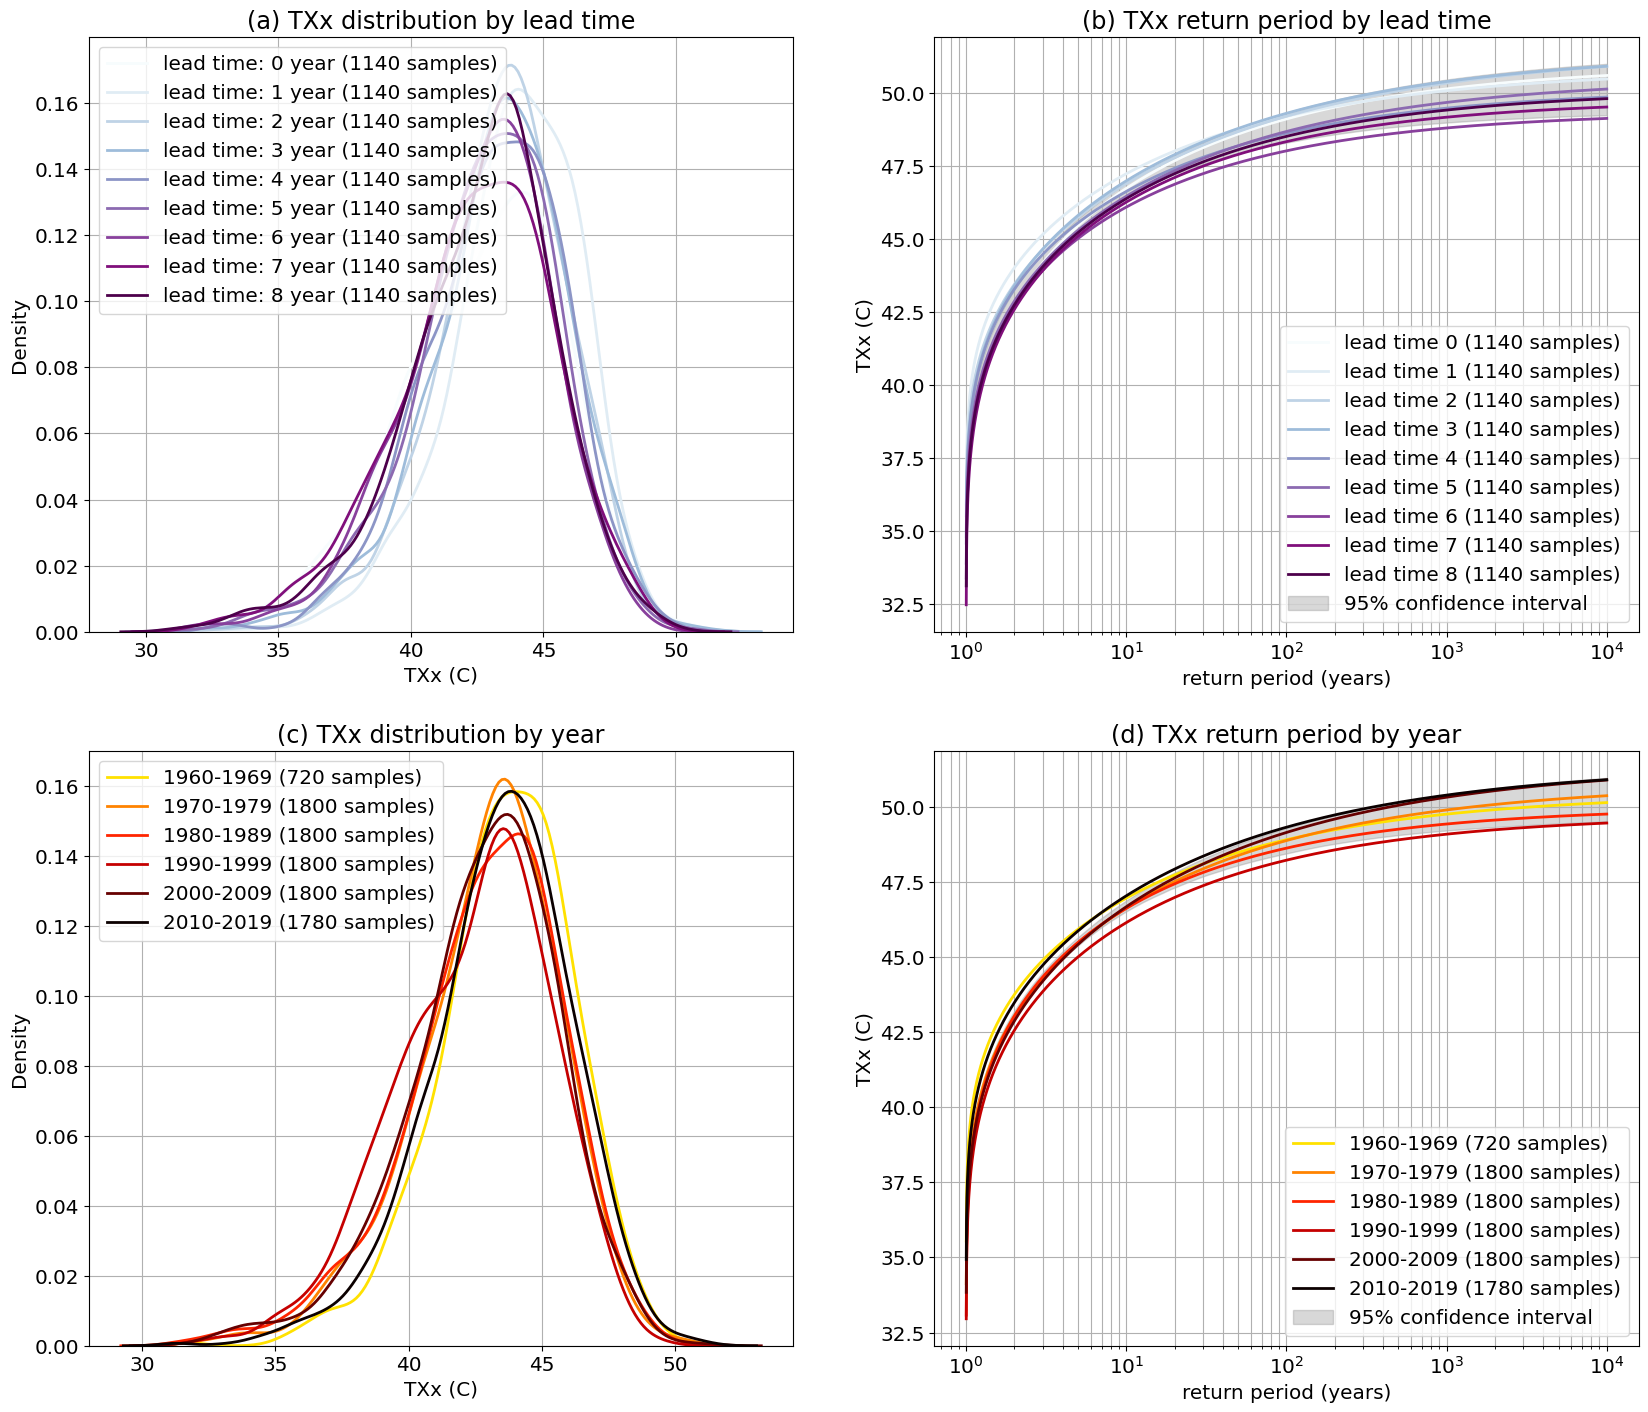

In [26]:
stability.create_plot(
    da_model,
    'TXx',
    [1960, 1970, 1980, 1990, 2000, 2010],
    uncertainty=True,
    return_method='gev',
    units='TXx (C)',
#    ylim=(0, 450),
)

/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


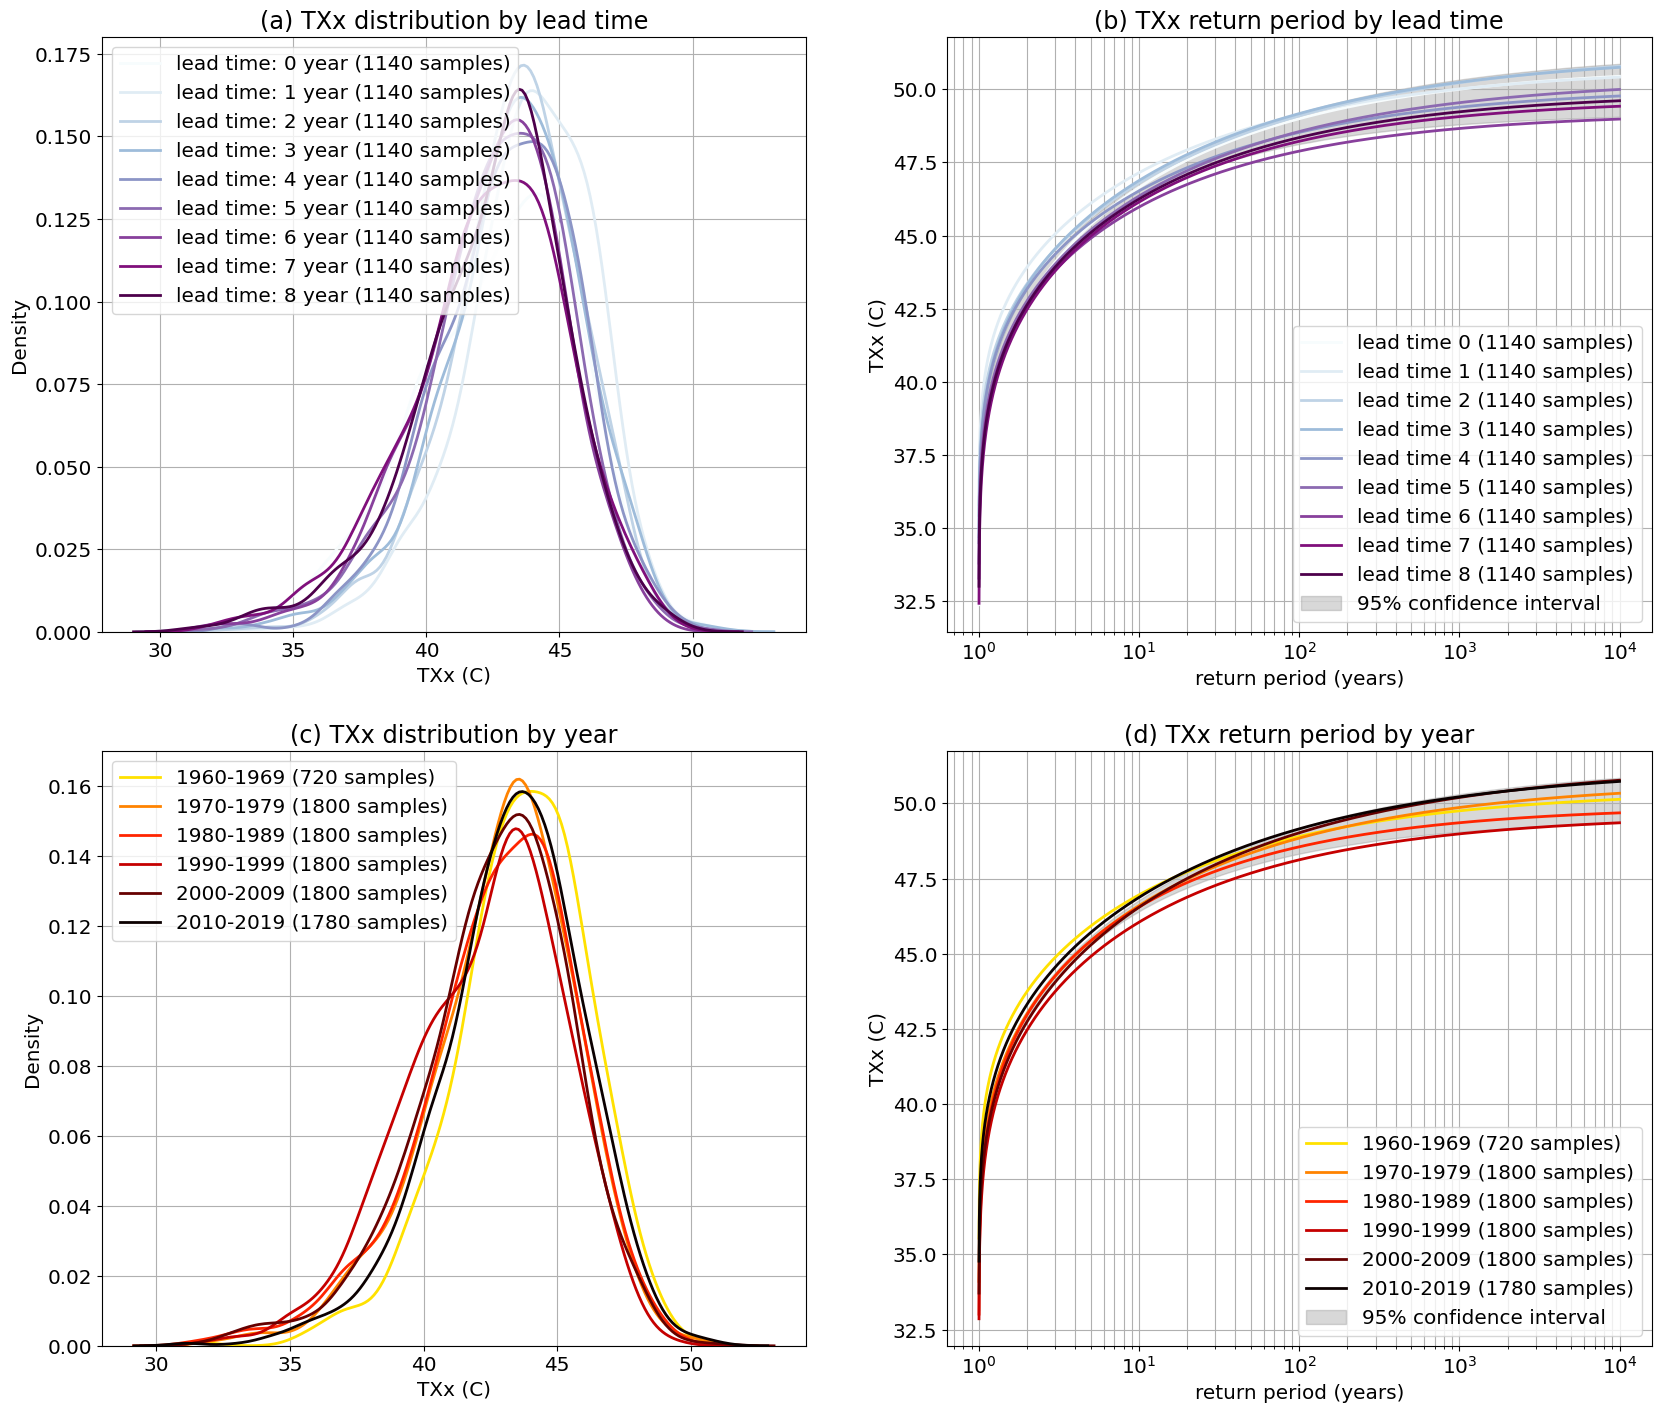

In [27]:
stability.create_plot(
    da_model_detrended,
    'TXx',
    [1960, 1970, 1980, 1990, 2000, 2010],
    uncertainty=True,
    return_method='gev',
    units='TXx (C)',
#    ylim=(0, 450),
)

In [28]:
gev_shape_model_detrended, gev_loc_model_detrended, gev_scale_model_detrended = eva.fit_gev(da_model_detrended_stacked.values)
print(f'Shape parameter: {gev_shape_model_detrended:.2f}')
print(f'Location parameter: {gev_loc_model_detrended:.2f}')
print(f'Scale parameter: {gev_scale_model_detrended:.2f}')

Shape parameter: 0.32
Location parameter: 41.92
Scale parameter: 2.95


### Mean correction

#### Additive

In [29]:
bias_mean_add = bias_correction.get_bias(
    da_model_detrended,
    da_obs_detrended,
    'additive',
    time_rounding='A',
    time_period=['1972-01-01', '2018-12-31']
)

In [30]:
da_model_detrended_bc_mean_add = bias_correction.remove_bias(da_model_detrended, bias_mean_add, 'additive')

In [31]:
da_model_detrended_bc_mean_add = da_model_detrended_bc_mean_add.compute()

In [32]:
da_model_detrended_bc_mean_add_stacked = da_model_detrended_bc_mean_add.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [33]:
gev_shape_model_detrended_bc_mean_add, gev_loc_model_detrended_bc_mean_add, gev_scale_model_detrended_bc_mean_add = eva.fit_gev(da_model_detrended_bc_mean_add_stacked.values)
print(f'Shape parameter: {gev_shape_model_detrended_bc_mean_add:.2f}')
print(f'Location parameter: {gev_loc_model_detrended_bc_mean_add:.2f}')
print(f'Scale parameter: {gev_scale_model_detrended_bc_mean_add:.2f}')

Shape parameter: 0.32
Location parameter: 39.57
Scale parameter: 2.95


#### Multiplicative

In [34]:
bias_mean_mulc = bias_correction.get_bias(
    da_model_detrended,
    da_obs_detrended,
    'multiplicative',
    time_rounding='A',
    time_period=['1972-01-01', '2018-12-31']
)

In [35]:
da_model_detrended_bc_mean_mulc = bias_correction.remove_bias(da_model_detrended, bias_mean_mulc, 'multiplicative')
da_model_detrended_bc_mean_mulc = da_model_detrended_bc_mean_mulc.compute()

In [36]:
da_model_detrended_bc_mean_mulc_stacked = da_model_detrended_bc_mean_mulc.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [37]:
gev_shape_model_detrended_bc_mean_mulc, gev_loc_model_detrended_bc_mean_mulc, gev_scale_model_detrended_bc_mean_mulc = eva.fit_gev(da_model_detrended_bc_mean_mulc_stacked.values)
print(f'Shape parameter: {gev_shape_model_detrended_bc_mean_mulc:.2f}')
print(f'Location parameter: {gev_loc_model_detrended_bc_mean_mulc:.2f}')
print(f'Scale parameter: {gev_scale_model_detrended_bc_mean_mulc:.2f}')

Shape parameter: 0.32
Location parameter: 39.61
Scale parameter: 2.79


### Quantile correction

In [38]:
nquantiles = 10
quantile_array = xc.sdba.utils.equally_spaced_nodes(nquantiles)

In [39]:
quantile_array

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])

In [40]:
da_model_detrended_q = nbutils.quantile(
    da_model_detrended_stacked,
    quantile_array,
    ['sample']
)

# time_utils.select_time_period(da_model_stacked.copy(), ['1972-01-01', '2018-12-31'])

In [41]:
da_model_detrended_q.values

array([37.83302154, 40.07029422, 41.25425344, 42.12486821, 42.87628761,
       43.51259738, 44.14256607, 44.80443849, 45.63083411, 46.94206443])

In [42]:
da_obs_detrended_q = nbutils.quantile(
    da_obs_detrended,
    quantile_array,
    ['time']
)

# time_utils.select_time_period(da_obs.copy(), ['1972-01-01', '2018-12-31']),

In [43]:
da_obs_detrended_q.values

array([37.80227741, 38.50055064, 39.23802282, 39.95185791, 40.37107825,
       41.00929461, 41.52584734, 41.72104536, 42.38381282, 43.26831034])

In [44]:
bias_quantile_add = da_model_detrended_q.values - da_obs_detrended_q.values

In [45]:
bias_quantile_add_cubic_fit = np.polyfit(quantile_array, bias_quantile_add, 3)

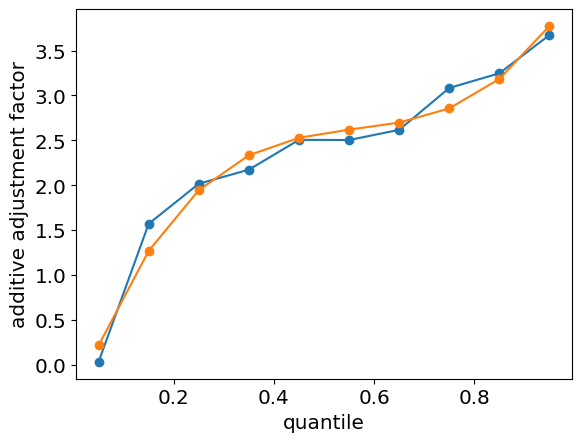

In [46]:
plt.plot(quantile_array, bias_quantile_add, marker='o')
cubic_data = np.polyval(bias_quantile_add_cubic_fit, quantile_array)
plt.plot(quantile_array, cubic_data, marker='o')
plt.xlabel('quantile')
plt.ylabel('additive adjustment factor')
plt.show()

In [47]:
bias_quantile_mulc = da_model_detrended_q.values / da_obs_detrended_q.values

In [48]:
bias_quantile_mulc_cubic_fit = np.polyfit(quantile_array, bias_quantile_mulc, 3)

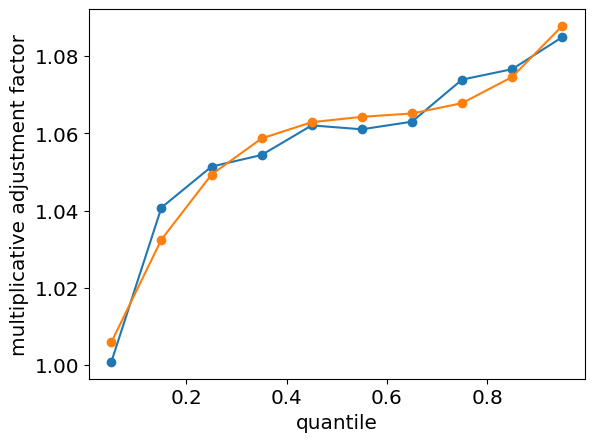

In [49]:
plt.plot(quantile_array, bias_quantile_mulc, marker='o')
cubic_data = np.polyval(bias_quantile_mulc_cubic_fit, quantile_array)
plt.plot(quantile_array, cubic_data, marker='o')
plt.xlabel('quantile')
plt.ylabel('multiplicative adjustment factor')
plt.show()

In [50]:
#def get_adjustment_factor(value, quantiles, adjustment_factors):
#    """Find the adjustment factor corresponding to the closest quantile."""
#
#    assert quantiles.shape == adjustment_factors.shape
#    
#    difference_array = np.absolute(quantiles - value)
#    index = difference_array.argmin()
#    adjustment_factor = adjustment_factors[index]
#
#    return adjustment_factor
#
#vget_adjustment_factor = np.vectorize(get_adjustment_factor, excluded=['quantiles', 'adjustment_factors'])


def get_smooth_adjustment_factor(value, data, af_cubic_fit):
    """Find the adjustment factor."""

    quantile = stats.percentileofscore(data, value) / 100
    af = np.polyval(af_cubic_fit, quantile)

    return af

vget_smooth_adjustment_factor = np.vectorize(get_smooth_adjustment_factor, excluded=['data', 'af_cubic_fit'])

#### Additive

In [51]:
#af_add = vget_adjustment_factor(
#    da_model_stacked.values,
#    quantiles=da_model_q.values,
#    adjustment_factors=bias_quantile_add,
#)
af_add = vget_smooth_adjustment_factor(
    da_model_detrended_stacked.values,
    data=da_model_detrended_stacked.values,
    af_cubic_fit=bias_quantile_add_cubic_fit,
)

In [52]:
da_model_detrended_bc_quantile_add = da_model_detrended_stacked - af_add

In [53]:
gev_shape_model_detrended_bc_quantile_add, gev_loc_model_detrended_bc_quantile_add, gev_scale_model_detrended_bc_quantile_add = eva.fit_gev(da_model_detrended_bc_quantile_add.values)
print(f'Shape parameter: {gev_shape_model_detrended_bc_quantile_add:.2f}')
print(f'Location parameter: {gev_loc_model_detrended_bc_quantile_add:.2f}')
print(f'Scale parameter: {gev_scale_model_detrended_bc_quantile_add:.2f}')

Shape parameter: 0.27
Location parameter: 39.87
Scale parameter: 1.94


#### Multiplicative

In [54]:
#af_mulc = vget_adjustment_factor(
#    da_model_stacked.values,
#    quantiles=da_model_q.values,
#    adjustment_factors=bias_quantile_mulc,
#)
af_mulc = vget_smooth_adjustment_factor(
    da_model_detrended_stacked.values,
    data=da_model_detrended_stacked.values,
    af_cubic_fit=bias_quantile_mulc_cubic_fit,
)

In [55]:
da_model_detrended_bc_quantile_mulc = da_model_detrended_stacked / af_mulc

In [56]:
gev_shape_model_detrended_bc_quantile_mulc, gev_loc_model_detrended_bc_quantile_mulc, gev_scale_model_detrended_bc_quantile_mulc = eva.fit_gev(da_model_detrended_bc_quantile_mulc.values)
print(f'Shape parameter: {gev_shape_model_detrended_bc_quantile_mulc:.2f}')
print(f'Location parameter: {gev_loc_model_detrended_bc_quantile_mulc:.2f}')
print(f'Scale parameter: {gev_scale_model_detrended_bc_quantile_mulc:.2f}')

Shape parameter: 0.29
Location parameter: 39.88
Scale parameter: 1.94


## Comparison

In [57]:
def fidelity_tests(da_target):
    """Perform fidelity tests."""
    
    similarity_scores = similarity.similarity_tests(da_target, da_obs)
    print('KS score:', similarity_scores['ks_statistic'].values)
    print('KS p-value:', similarity_scores['ks_pval'].values)
    print('AD score:', similarity_scores['ad_statistic'].values)
    print('AD p-value:', similarity_scores['ad_pval'].values)

    moments.create_plot(
        da_model_detrended,
        da_obs_detrended,
        da_bc_fcst=da_target,
    )

In [58]:
xmax = np.max([da_model_detrended_stacked.values.max(), da_obs_detrended.values.max()]) + 1
xmin = np.min([da_model_detrended_stacked.values.min(), da_obs_detrended.values.min()]) - 1

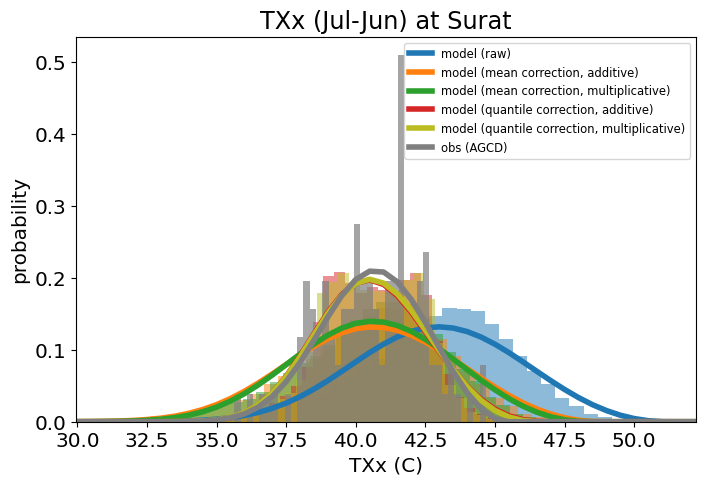

In [59]:
fig, ax = plt.subplots(figsize=[8, 5])
gev_xvals = np.arange(20, 65, 0.5)

da_model_detrended_stacked.plot.hist(bins=40, density=True, color='tab:blue', alpha=0.5)
gev_pdf_model_detrended = gev.pdf(gev_xvals, gev_shape_model_detrended, gev_loc_model_detrended, gev_scale_model_detrended)
plt.plot(gev_xvals, gev_pdf_model_detrended, color='tab:blue', linewidth=4.0, label='model (raw)')

da_model_detrended_bc_mean_add_stacked.plot.hist(bins=40, density=True, color='tab:orange', alpha=0.5)
gev_pdf_model_detrended_bc_mean_add = gev.pdf(
    gev_xvals,
    gev_shape_model_detrended_bc_mean_add,
    gev_loc_model_detrended_bc_mean_add,
    gev_scale_model_detrended_bc_mean_add
)
plt.plot(
    gev_xvals,
    gev_pdf_model_detrended_bc_mean_add,
    color='tab:orange',
    linewidth=4.0,
    label='model (mean correction, additive)'
)

da_model_detrended_bc_mean_mulc_stacked.plot.hist(bins=40, density=True, color='tab:green', alpha=0.5)
gev_pdf_model_detrended_bc_mean_mulc = gev.pdf(
    gev_xvals,
    gev_shape_model_detrended_bc_mean_mulc,
    gev_loc_model_detrended_bc_mean_mulc,
    gev_scale_model_detrended_bc_mean_mulc
)
plt.plot(
    gev_xvals,
    gev_pdf_model_detrended_bc_mean_mulc,
    color='tab:green',
    linewidth=4.0,
    label='model (mean correction, multiplicative)'
)

da_model_detrended_bc_quantile_add.plot.hist(bins=40, density=True, color='tab:red', alpha=0.5)
gev_pdf_model_detrended_bc_quantile_add = gev.pdf(
    gev_xvals,
    gev_shape_model_detrended_bc_quantile_add,
    gev_loc_model_detrended_bc_quantile_add,
    gev_scale_model_detrended_bc_quantile_add
)
plt.plot(
    gev_xvals,
    gev_pdf_model_detrended_bc_quantile_add,
    color='tab:red',
    linewidth=4.0,
    label='model (quantile correction, additive)'
)

da_model_detrended_bc_quantile_mulc.plot.hist(bins=40, density=True, color='tab:olive', alpha=0.5)
gev_pdf_model_detrended_bc_quantile_mulc = gev.pdf(
    gev_xvals,
    gev_shape_model_detrended_bc_quantile_mulc,
    gev_loc_model_detrended_bc_quantile_mulc,
    gev_scale_model_detrended_bc_quantile_mulc
)
plt.plot(
    gev_xvals,
    gev_pdf_model_detrended_bc_quantile_mulc,
    color='tab:olive',
    linewidth=4.0,
    label='model (quantile correction, multiplicative)'
)

da_obs_detrended.plot.hist(bins=40, density=True, color='tab:gray', alpha=0.7)
gev_pdf_obs_detrended = gev.pdf(gev_xvals, gev_shape_obs_detrended, gev_loc_obs_detrended, gev_scale_obs_detrended)
plt.plot(gev_xvals, gev_pdf_obs_detrended, color='tab:gray', linewidth=4.0, label='obs (AGCD)')

plt.xlabel('TXx (C)')
plt.ylabel('probability')
plt.title(f'TXx (Jul-Jun) at {location}')

plt.xlim(xmin, xmax)
plt.legend(fontsize='small')
plt.savefig(f'txx_{location}_gevs.png', bbox_inches='tight', facecolor='white')
plt.show()

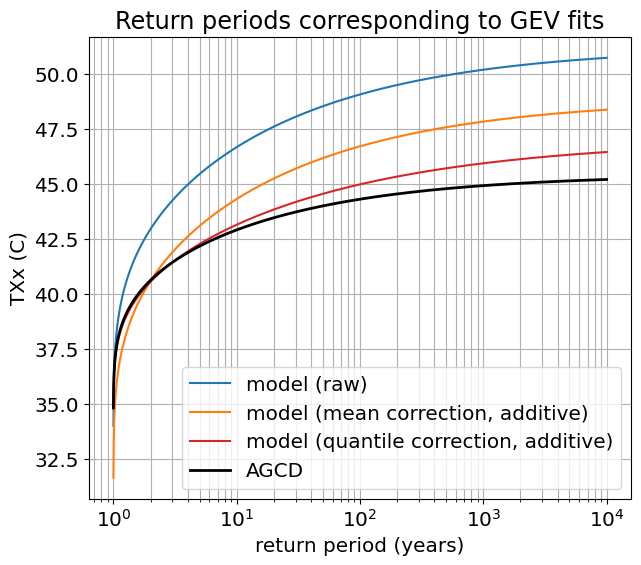

In [60]:
fig = plt.figure(figsize=[7, 6])
#ax1 = fig.add_subplot(211)
#ax2 = fig.add_subplot(212)
ax2 = fig.add_subplot(111)

#ax1.plot(gev_xvals, gev_pdf_model_detrended, color='tab:blue', label='model (raw)')
return_periods_model_detrended, return_values_model_detrended = stability.return_curve(
    da_model_detrended,
    'gev',
    params=[gev_shape_model_detrended, gev_loc_model_detrended, gev_scale_model_detrended],
)
ax2.plot(return_periods_model_detrended, return_values_model_detrended, label='model (raw)', color='tab:blue')

#ax1.plot(gev_xvals, gev_pdf_model_detrended_bc_mean_add, color='tab:orange', label='model (mean correction, additive)')
return_periods_model_detrended_bc_mean_add, return_values_model_detrended_bc_mean_add = stability.return_curve(
    da_model_detrended_bc_mean_add,
    'gev',
    params=[gev_shape_model_detrended_bc_mean_add, gev_loc_model_detrended_bc_mean_add, gev_scale_model_detrended_bc_mean_add],
)
ax2.plot(return_periods_model_detrended_bc_mean_add, return_values_model_detrended_bc_mean_add, label='model (mean correction, additive)', color='tab:orange')

#ax1.plot(gev_xvals, gev_pdf_model_detrended_bc_quantile_add, color='tab:red', label='model (quantile correction, additive)')
return_periods_model_detrended_bc_quantile_add, return_values_model_detrended_bc_quantile_add = stability.return_curve(
    da_model_detrended_bc_quantile_add,
    'gev',
    params=[gev_shape_model_detrended_bc_quantile_add, gev_loc_model_detrended_bc_quantile_add, gev_scale_model_detrended_bc_quantile_add],
)
ax2.plot(return_periods_model_detrended_bc_quantile_add, return_values_model_detrended_bc_quantile_add, label='model (quantile correction, additive)', color='tab:red')

#ax1.plot(gev_xvals, gev_pdf_obs_detrended, color='black', linewidth=2.0, label='AGCD')
return_periods_obs_detrended, return_values_obs_detrended = stability.return_curve(
    da_obs_detrended,
    'gev',
    params=[gev_shape_obs_detrended, gev_loc_obs_detrended, gev_scale_obs_detrended],
)
ax2.plot(return_periods_obs_detrended, return_values_obs_detrended, label='AGCD', color='black', linewidth=2.0)

#ax1.grid()
#ax1.set_xlabel('TXx (C)')
#ax1.set_ylabel('probability')
#ax1.axvline(agcd_max, color='0.5', linestyle='--')
#ax1.set_title('(a) GEV fit to data')
#ax1.set_xlim([0, 450])
#ax1.legend()

ax2.legend()
#ax2.axhline(agcd_max, color='0.5', linestyle='--')
ax2.set_xscale('log')
ax2.set_xlabel('return period (years)')
ax2.set_ylabel('TXx (C)')
ax2.set_title('Return periods corresponding to GEV fits')
#ax2.set_ylim([0, 700])
ax2.grid(which='both')
plt.savefig(f'txx_{location}_return_curves.png', bbox_inches='tight', facecolor='white')
plt.show()

### Raw data

In [61]:
similarity_ds = similarity.similarity_tests(da_model_detrended, da_obs_detrended)
print('KS score:', similarity_ds['ks_statistic'].values)
print('KS p-value:', similarity_ds['ks_pval'].values)
print('AD score:', similarity_ds['ad_statistic'].values)
print('AD p-value:', similarity_ds['ad_pval'].values)

KS score: 0.4870405
KS p-value: 5.301725e-25
AD score: 66.81883
AD p-value: 0.001


### Additive - mean correction

KS score: 0.12760441
KS p-value: 0.047564972
AD score: 3.1438925
AD p-value: 0.017117478


INFO:root:mean: Obs = 40.56317138671874, Model 95% CI =42.38989336106464 to 43.389948492902654
INFO:root:standard deviation: Obs = 1.8065496671893246, Model 95% CI =2.3687170469659766 to 3.1947729082450222
INFO:root:skew: Obs = -0.23945803484253483, Model 95% CI =-1.0393597906033376 to -0.1248740502104951
INFO:root:kurtosis: Obs = -0.2600737916385367, Model 95% CI =-0.5381675270281562 to 2.4169801032730125
INFO:root:GEV shape: Obs = 0.3424116884127585, Model 95% CI =0.2782196072433656 to 0.5595147630066434
INFO:root:GEV location: Obs = 39.97471383605871, Model 95% CI =41.54683187780023 to 42.64321242513904
INFO:root:GEV scale: Obs = 1.869807979318661, Model 95% CI =2.471260837363019 to 3.4324204018965654
INFO:root:mean: Obs = 40.56317138671874, Bias corrected model 95% CI =40.0348327630815 to 41.005431058866726
INFO:root:standard deviation: Obs = 1.8065496671893246, Bias corrected model 95% CI =2.337803041396606 to 3.2212709834430187
INFO:root:skew: Obs = -0.23945803484253483, Bias cor

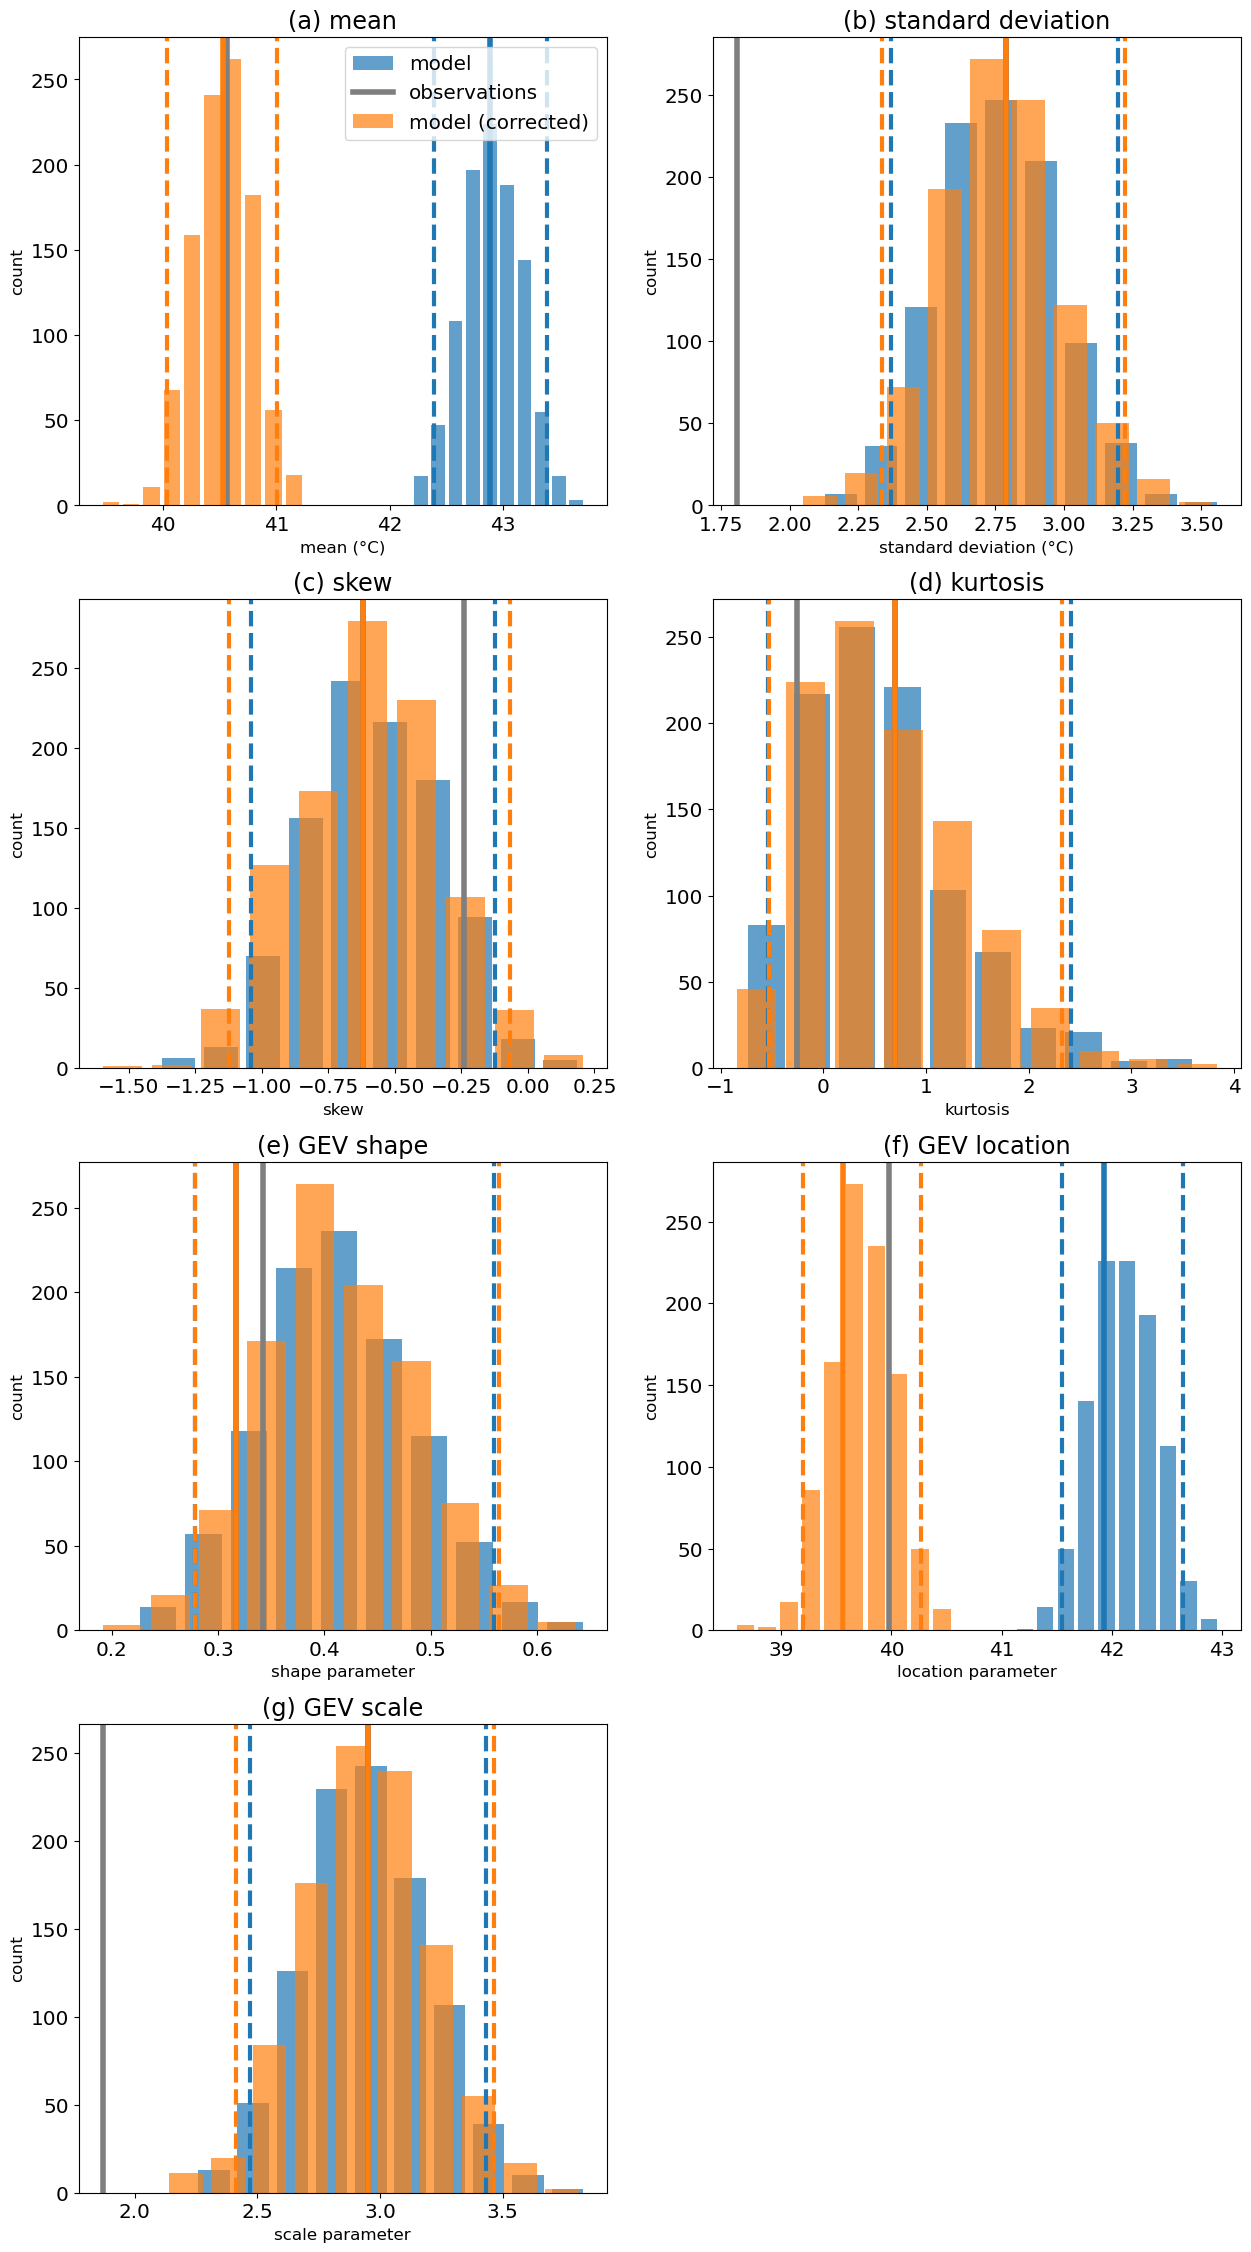

In [62]:
fidelity_tests(da_model_detrended_bc_mean_add)

### Multiplicative - mean correction

KS score: 0.1162009
KS p-value: 0.08960556
AD score: 2.0947008
AD p-value: 0.044607453


INFO:root:mean: Obs = 40.56317138671874, Model 95% CI =42.36348731726253 to 43.413446488145524
INFO:root:standard deviation: Obs = 1.8065496671893246, Model 95% CI =2.377082112415468 to 3.1869147421271418
INFO:root:skew: Obs = -0.23945803484253483, Model 95% CI =-1.1271290768506383 to -0.1225257802870294
INFO:root:kurtosis: Obs = -0.2600737916385367, Model 95% CI =-0.4687837185225258 to 2.3949714063009786
INFO:root:GEV shape: Obs = 0.3424116884127585, Model 95% CI =0.2795678550080809 to 0.5584056418782458
INFO:root:GEV location: Obs = 39.97471383605871, Model 95% CI =41.477468837118174 to 42.69090548946041
INFO:root:GEV scale: Obs = 1.869807979318661, Model 95% CI =2.492393311833327 to 3.4221618736165245
INFO:root:mean: Obs = 40.56317138671874, Bias corrected model 95% CI =40.0254715401309 to 40.984302120654554
INFO:root:standard deviation: Obs = 1.8065496671893246, Bias corrected model 95% CI =2.2028820014103303 to 3.0061947159644777
INFO:root:skew: Obs = -0.23945803484253483, Bias co

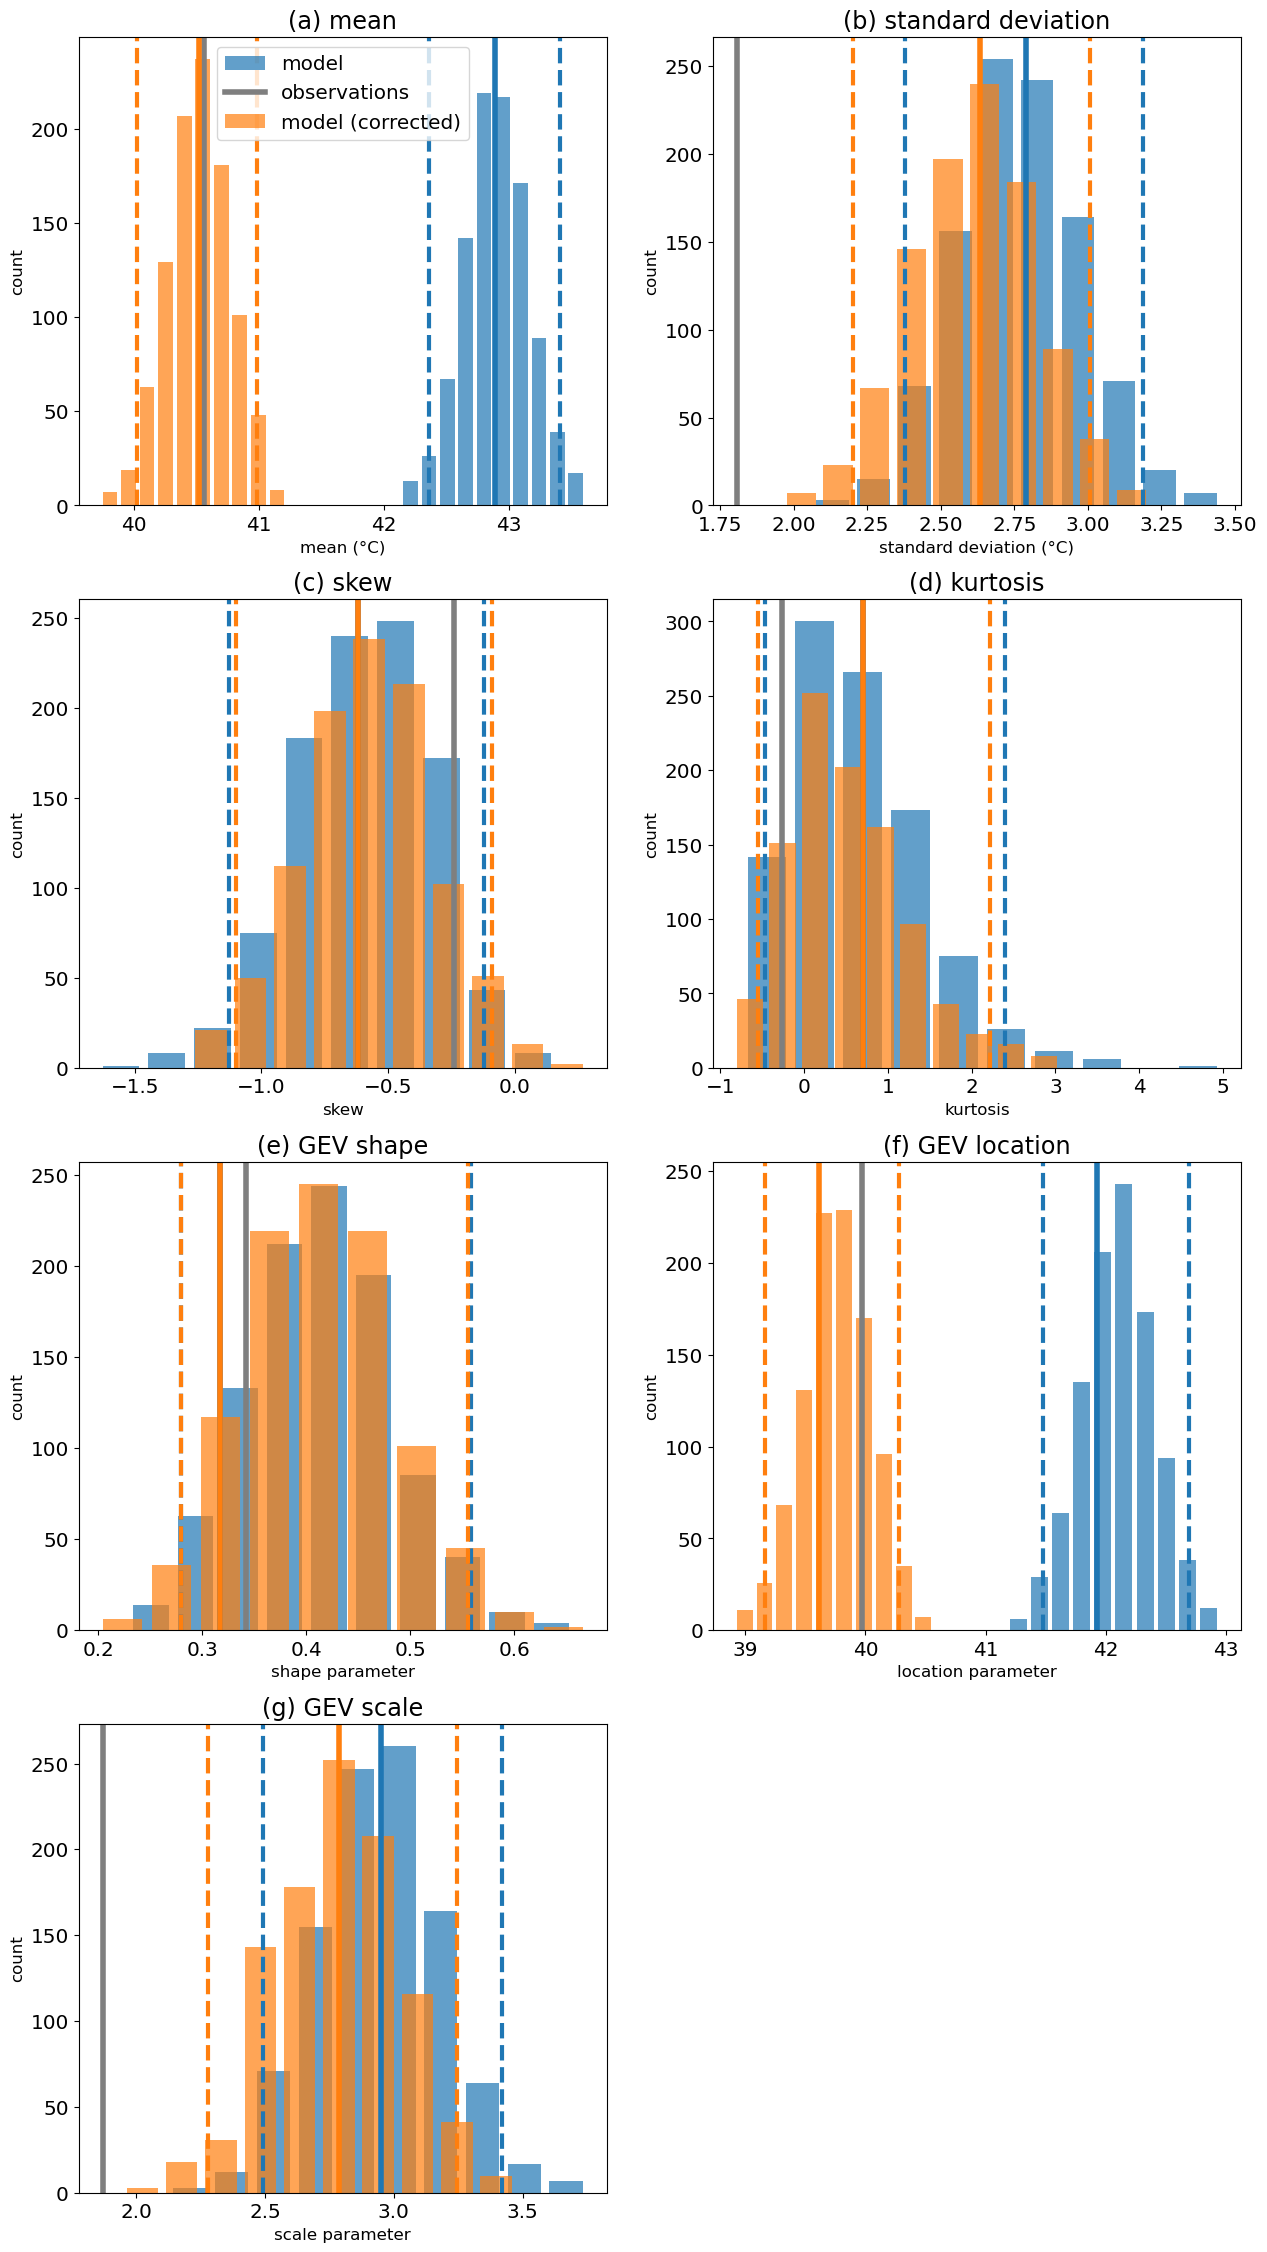

In [63]:
fidelity_tests(da_model_detrended_bc_mean_mulc)

### Additive - quantile correction

KS score: 0.07510911
KS p-value: 0.52781403
AD score: -0.3823414
AD p-value: 0.25


INFO:root:mean: Obs = 40.56317138671874, Model 95% CI =42.39685859650095 to 43.414332340612546
INFO:root:standard deviation: Obs = 1.8065496671893246, Model 95% CI =2.3710478402469986 to 3.193740318128359
INFO:root:skew: Obs = -0.23945803484253483, Model 95% CI =-1.0927256761746633 to -0.07405369519353648
INFO:root:kurtosis: Obs = -0.2600737916385367, Model 95% CI =-0.5068385605795874 to 2.1810252495014577
INFO:root:GEV shape: Obs = 0.3424116884127585, Model 95% CI =0.2802679867871712 to 0.5503523911394682
INFO:root:GEV location: Obs = 39.97471383605871, Model 95% CI =41.51068496886547 to 42.672201079794505
INFO:root:GEV scale: Obs = 1.869807979318661, Model 95% CI =2.459879448051385 to 3.439153464216621
INFO:root:mean: Obs = 40.56317138671874, Bias corrected model 95% CI =40.219033017837845 to 40.872699270553376
INFO:root:standard deviation: Obs = 1.8065496671893246, Bias corrected model 95% CI =1.5636878124732854 to 2.16121146327064
INFO:root:skew: Obs = -0.23945803484253483, Bias co

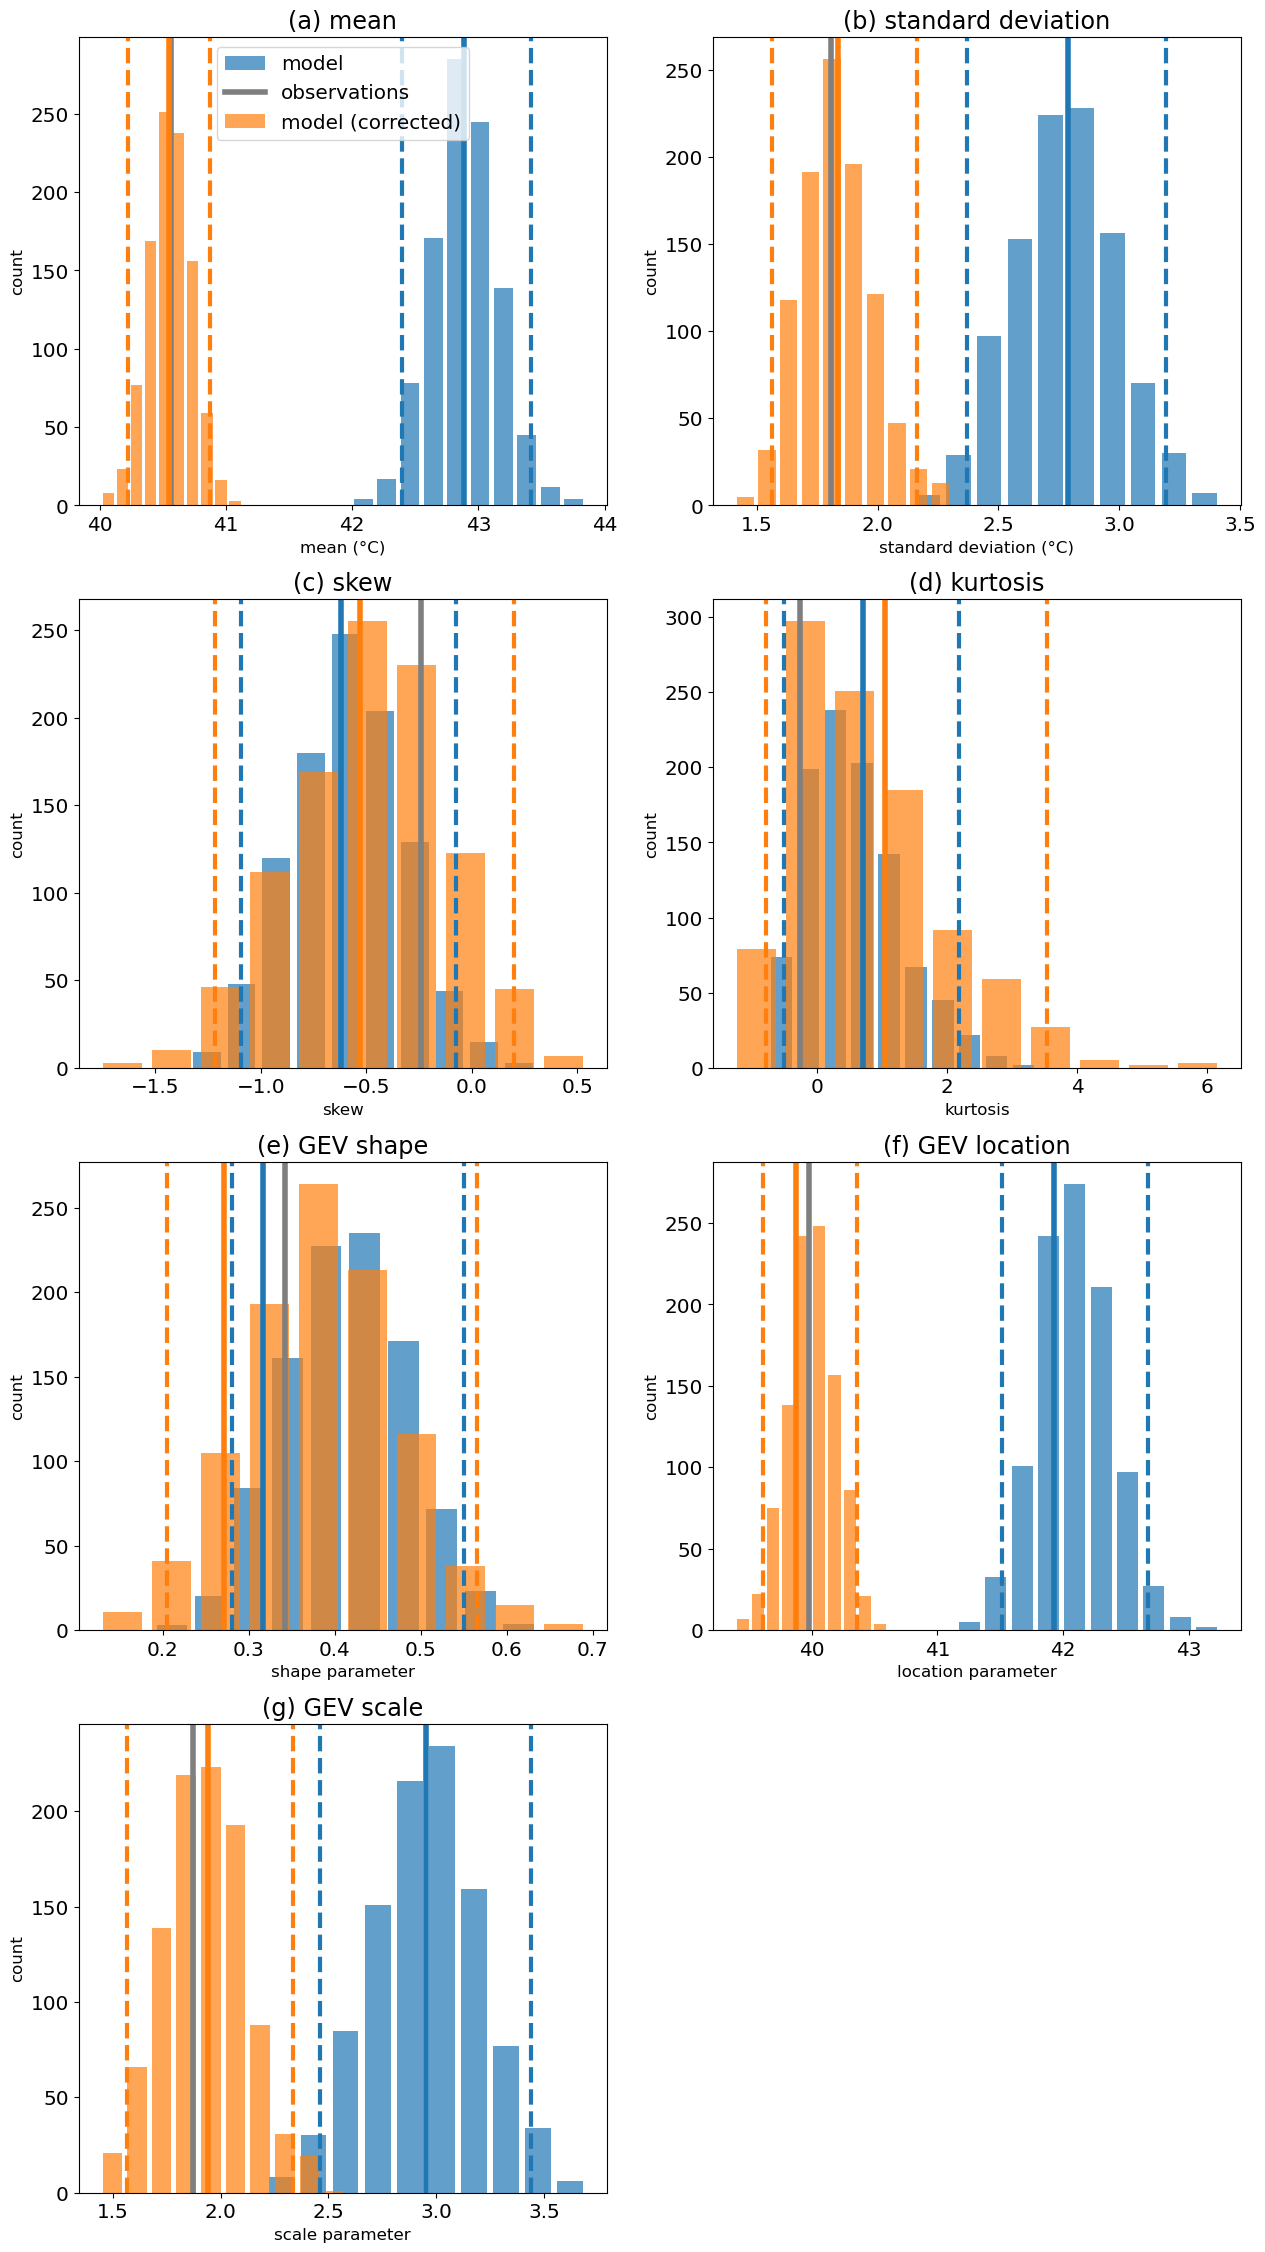

In [64]:
fidelity_tests(da_model_detrended_bc_quantile_add.unstack())

### Multiplicative - quantile correction

KS score: 0.07530404
KS p-value: 0.52449346
AD score: -0.34167537
AD p-value: 0.25


INFO:root:mean: Obs = 40.56317138671874, Model 95% CI =42.364823882408125 to 43.412514108555705
INFO:root:standard deviation: Obs = 1.8065496671893246, Model 95% CI =2.3493376495860314 to 3.2152852150870292
INFO:root:skew: Obs = -0.23945803484253483, Model 95% CI =-1.0693758439851966 to -0.07045904177252034
INFO:root:kurtosis: Obs = -0.2600737916385367, Model 95% CI =-0.5436417863685202 to 2.351392804238446
INFO:root:GEV shape: Obs = 0.3424116884127585, Model 95% CI =0.272250869468477 to 0.546781977535075
INFO:root:GEV location: Obs = 39.97471383605871, Model 95% CI =41.49062126397559 to 42.643793678295644
INFO:root:GEV scale: Obs = 1.869807979318661, Model 95% CI =2.4674329933355663 to 3.4254251010362267
INFO:root:mean: Obs = 40.56317138671874, Bias corrected model 95% CI =40.20067577471715 to 40.88730192112068
INFO:root:standard deviation: Obs = 1.8065496671893246, Bias corrected model 95% CI =1.5360682324159876 to 2.111432029829775
INFO:root:skew: Obs = -0.23945803484253483, Bias co

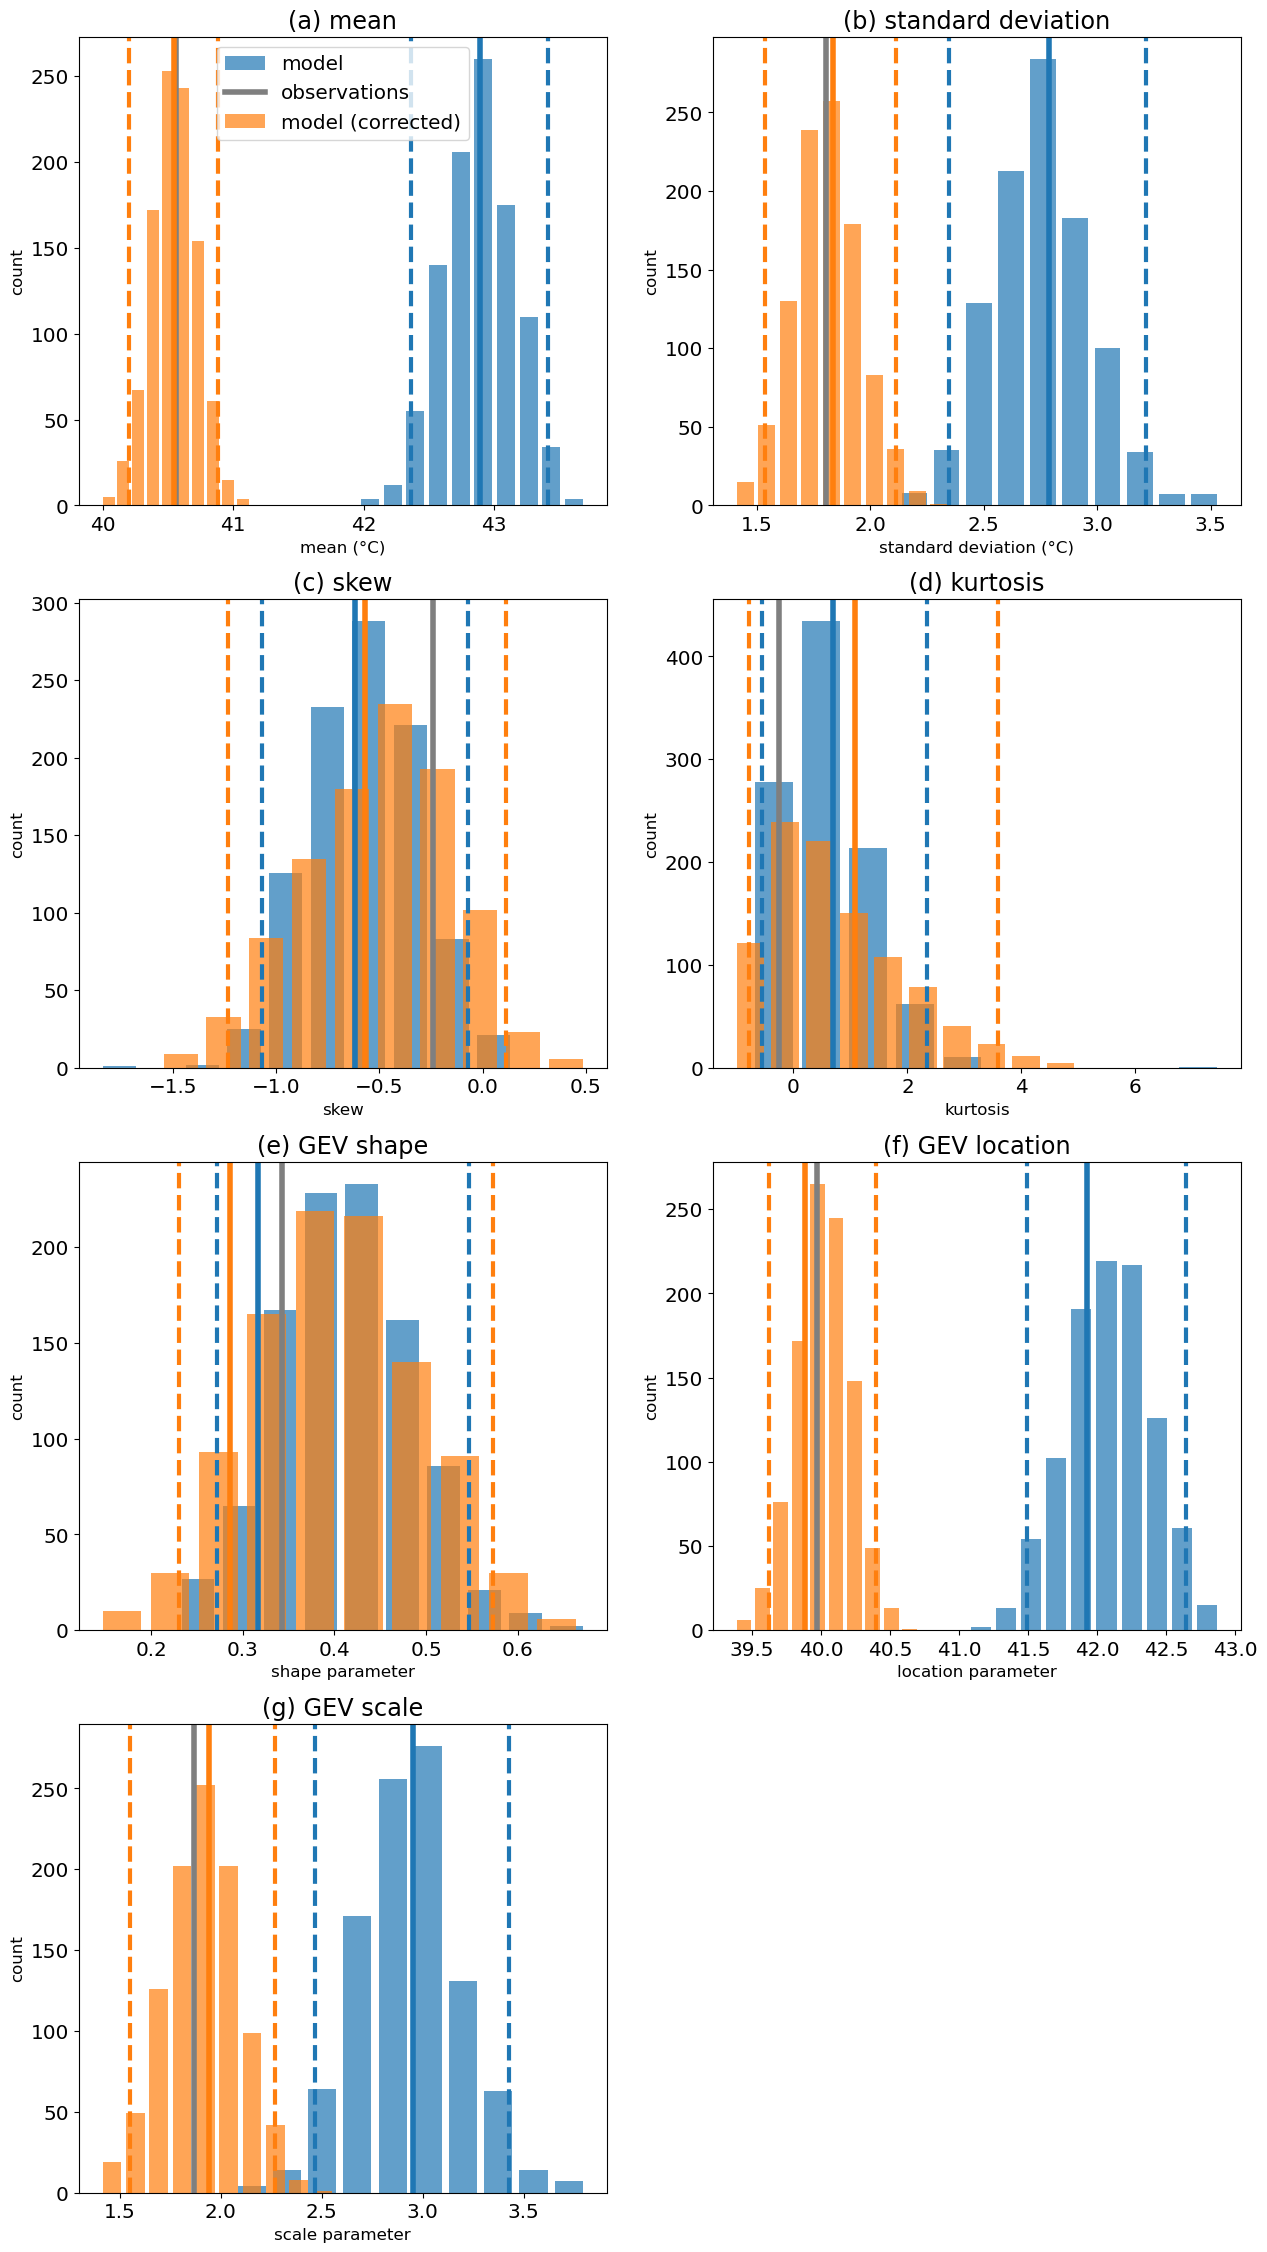

In [65]:
fidelity_tests(da_model_detrended_bc_quantile_mulc.unstack())